This notebook is to analyse the results 


In [1]:
import sys
from jin_utils import get_mypkg_path
pkgpath = get_mypkg_path()
sys.path.append(pkgpath)
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT

In [2]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space
#

In [3]:
import time
from collections import defaultdict
from easydict import EasyDict as edict
from pathlib import Path

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
import pandas as pd

from utils.misc import save_pkl, load_pkl, num2str, str2num
plt.style.use(FIG_ROOT/"base.mplstyle")

In [19]:
res_fold = RES_ROOT/"NewSinFixASplineTuneh_Xbinary_sizexy-50x5_noise-0d5_kernel-None_fmodel-LIN_noise-normal"
def _sort_fn(fil):
    parts = fil.stem.split("_")
    nums = []
    for p in parts: 
        index = p.find("-")
        nums.append(str2num(p[(index+1):]))
    return nums
fils = list(res_fold.glob("size*.pkl"));
fils = sorted(fils, key=_sort_fn);

In [20]:
# extract the data into a dataframe
df_dict = ddict(list)
for fil in tqdm(fils): 
    res = load_pkl(fil, verbose=False)
    for re in res: 
        for ky in ["naive", "wvar", "naive-nospl"]:
            if ky not in re.keys(): continue
            df_dict["eps"].append(re[ky]["eps"])
            df_dict["empcv"].append(re[ky]["in_sets"])
            df_dict["method"].append(ky)
            if "size" in re["info"]:
                df_dict["size"].append(re["info"]["size"])
            else:
                df_dict["size"].append(re["info"]["ntrain"])
            df_dict["hfct"].append(re["info"]["hfct"])
            df_dict["seed"].append(re["info"]["seed"])
            #df_dict["h"].append(re["info"]["h"])
    
df = pd.DataFrame(df_dict);

  0%|                                                                                                                              | 0/5 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.30it/s]


In [21]:
sizes = np.sort(np.unique(df["size"]))
print(sizes)

[  100   500  1000  5000 10000]


<Axes: ylabel='Count'>

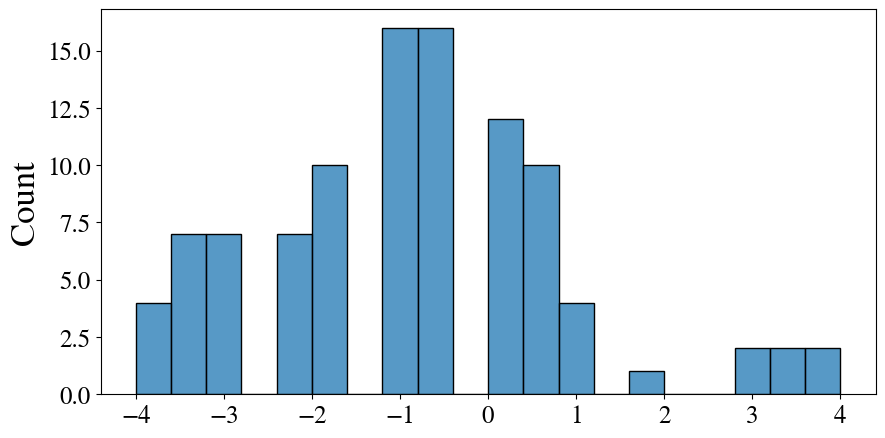

In [22]:
kpidxs = np.bitwise_and(df["method"]=="naive", df["size"]==sizes[-1])
shfcts = np.array(df["hfct"][kpidxs])
sns.histplot(np.log10(shfcts), bins=20)

[0.07844966 0.00940205 0.01001246]
[0.00385279 0.00137699 0.00146122]
[0.00183953 0.00084843 0.00081747]
[0.00030605 0.00018056 0.00018137]
[0.00016112 0.00011088 0.0001113 ]


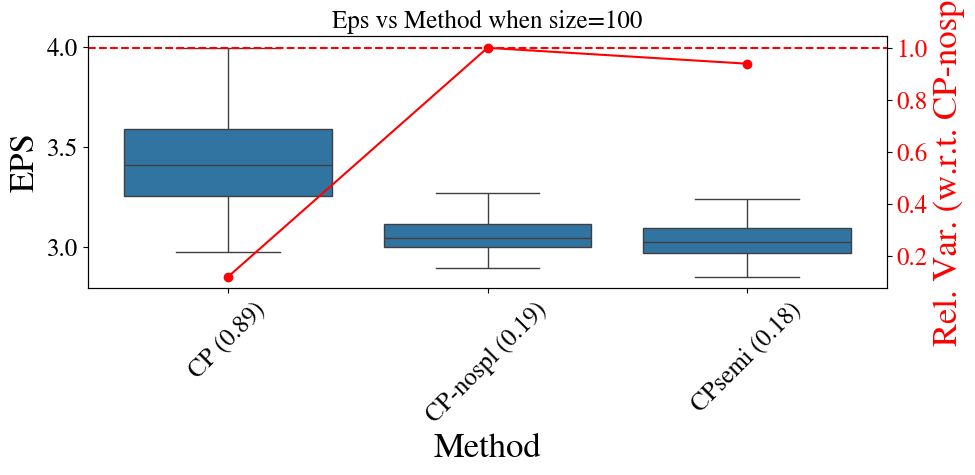

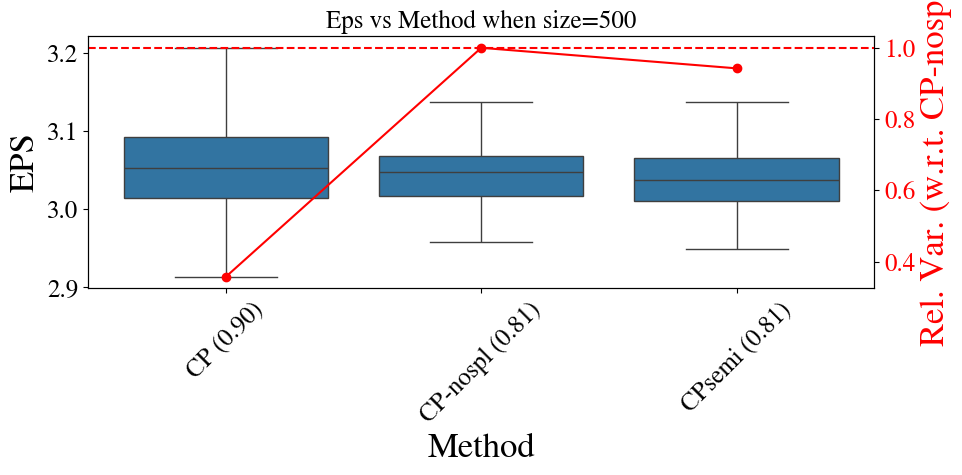

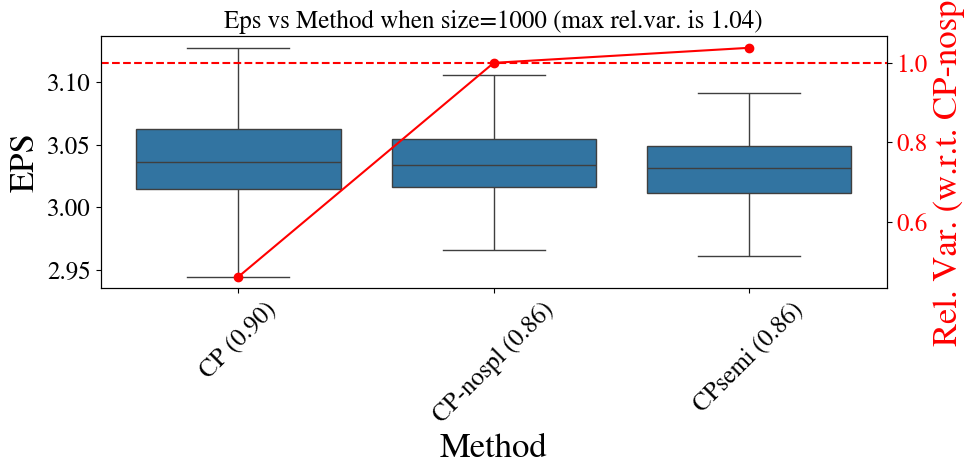

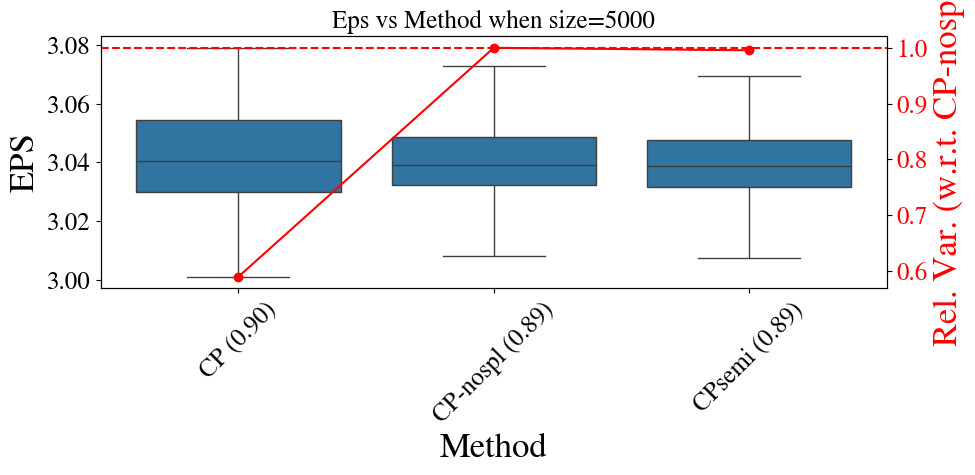

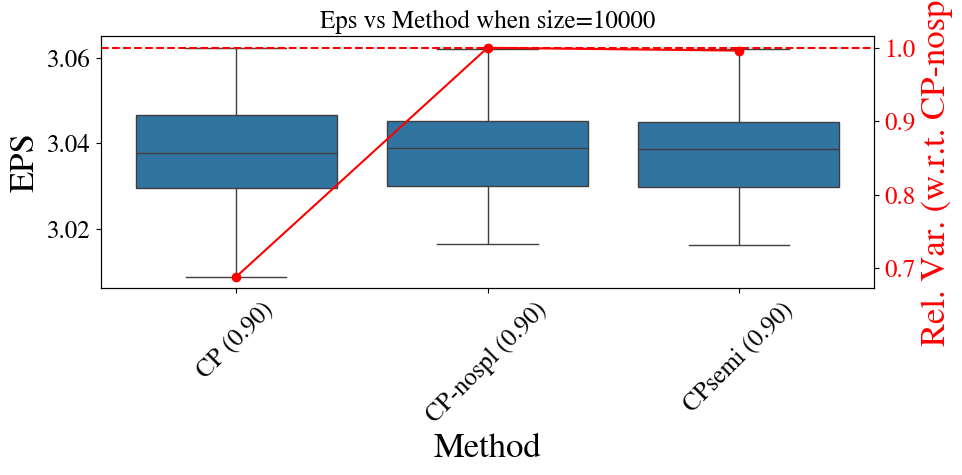

In [23]:
def _sort_fn(x, is_print=False):
    """Sort the method names
    """
    if x.startswith("naive-nospl"):
        v = "CP-nospl" if is_print else -1
    elif x.startswith("naive"): 
        v = "CP" if is_print else -2
    elif x.startswith("wvar"):
        v = "CPsemi" if is_print else 0
    return v

size = sizes[-2]
for size in sizes:
    kpidxs0 =df["size"]==size
    sel_df = df[kpidxs0]

    names = np.unique(sel_df["method"])
    order_names = sorted(names, key=_sort_fn)
    print_names = [_sort_fn(name, is_print=True) for name in order_names]

    vars = sel_df.groupby(["method"])["eps"].var()
    vars = np.array(vars[order_names])
    print(vars)
    rl_vars = vars[1]/vars

    cvs = sel_df.groupby(["method"])["empcv"].mean()
    cvs = np.array(cvs[order_names])
    # add cv in print_names
    print_names = [f"{print_names[i]} ({cvs[i]:.2f})" for i in range(len(print_names))]

    fig, ax1 = plt.subplots()
    if np.max(rl_vars) > 1.01: 
        plt.title(f"Eps vs Method when size={size} (max rel.var. is {np.max(rl_vars):.2f})")
    else:
        plt.title(f"Eps vs Method when size={size}")
    sns.boxplot(data=sel_df, x="method", y="eps", order=order_names, showfliers=False, ax=ax1)
    ax1.set_xticks(ticks=range(len(order_names)), labels=print_names, rotation=45);
    ax1.set_ylabel("EPS")
    ax1.set_xlabel("Method")

    ax2 = ax1.twinx()
    ax2.plot(rl_vars, "ro-")
    ax2.axhline(1, color='r', linestyle='--')
    ax2.set_ylabel("Rel. Var. (w.r.t. CP-nospl)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    fig.tight_layout()  
    #plt.savefig(res_fold/f"eps_vs_method_size{size}.jpg")
